# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import random

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [ ]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip

--2021-05-14 19:17:38--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-05-14 19:17:38--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip.3’

stanfordSentimentTr 100%[===================>]   6.08M  5.08MB/s    in 1.2s    

2021-05-14 19:17:39 (5.08 MB/s) - ‘stanfordSentimentTreebank.zip.3’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOS

In [ ]:
import os
import numpy as np

class StanfordTreeBank:
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
novel ['alan', 'warner', 'answer', 'irvine']
lolita ['spooky', 'sulky', 'turn']
it ['cutes', 'nor']
noir ['salton', 'works', 'keeping', 'nasty']
landscapes ['against', 'frozen', 'grenoble', 'geneva']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [ ]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        self.data = data
        self.samples = None
        self.num_contexts = num_contexts
        self.num_tokens = len(self.data.index_by_token)
        self.num_negative_samples = num_negative_samples
    
    def generate_dataset(self, context_length=5):
        self.samples = []
        for i in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(context_length)
            for word in other_words:
                negative_indices = []
                while len(negative_indices) < num_negative_samples:
                    generated_index = random.randrange(self.num_tokens)
                    generated_word = self.data.token_by_index[generated_index]
                    if not (generated_word in other_words):
                        negative_indices.append(generated_index)
                
                self.samples.append((self.data.index_by_token[center_word], [self.data.index_by_token[word], *negative_indices]))
        
    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, index):
        input_vector, output = self.samples[index]

        output_indices = torch.tensor(output)
        output_target = torch.zeros_like(output_indices)
        output_target[0] = 1.0
        
        return input_vector, output_indices, output_target

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 8667, output indices: tensor([ 1091, 13184, 12082,  5582,  5129, 14636,  8669,  3874, 16505,  7028,
        18749]), output target: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [ ]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.ouput = nn.Linear(10, num_tokens, bias=False)
        self.num_tokens = num_tokens
        
    def forward(self, input_index_batch, output_indices_batch):
        results = []
        for input_index, output_index in zip(input_index_batch, output_indices_batch):
            sample = torch.zeros(self.num_tokens)
            sample[input_index] = 1.0

            input_results = self.input(sample)
            output_results = self.ouput(input_results)
            results.append(output_results[output_index])
        results_tensor = torch.stack(results)
        
        return results_tensor
    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (ouput): Linear(in_features=10, out_features=19538, bias=False)
)

In [ ]:
def extract_word_vectors(nn_model):
    input_vectors, output_vectors = nn_model.input.weight.T, nn_model.ouput.weight
    return torch.clone(input_vectors), torch.clone(output_vectors)

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [ ]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct = 0
        total = 0
        for i_step, (x_i, x_o, y) in enumerate(train_loader):
            prediction = model(x_i, x_o)
            y = y.type_as(prediction)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct += torch.sum(indices == 0)
            total += y.shape[0]
            
            loss_accum += loss_value

        
        scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct) / total
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        dataset.generate_dataset()
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [ ]:
optimizer = optim.SGD(nn_model.parameters(), lr=2e1, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 40)

Epoch 0, Average loss: 0.661884, Train accuracy: 0.119967
Epoch 1, Average loss: 0.424231, Train accuracy: 0.241266
Epoch 2, Average loss: 0.324943, Train accuracy: 0.286314
Epoch 3, Average loss: 0.296920, Train accuracy: 0.296871
Epoch 4, Average loss: 0.285262, Train accuracy: 0.304183
Epoch 5, Average loss: 0.277790, Train accuracy: 0.312756
Epoch 6, Average loss: 0.273816, Train accuracy: 0.315736
Epoch 7, Average loss: 0.271127, Train accuracy: 0.317290
Epoch 8, Average loss: 0.269085, Train accuracy: 0.323593
Epoch 9, Average loss: 0.266633, Train accuracy: 0.331398
Epoch 10, Average loss: 0.264259, Train accuracy: 0.338699
Epoch 11, Average loss: 0.261736, Train accuracy: 0.347012
Epoch 12, Average loss: 0.259521, Train accuracy: 0.353402
Epoch 13, Average loss: 0.256833, Train accuracy: 0.365079
Epoch 14, Average loss: 0.255851, Train accuracy: 0.367092
Epoch 15, Average loss: 0.253276, Train accuracy: 0.377102
Epoch 16, Average loss: 0.250887, Train accuracy: 0.386506
Epoch 1

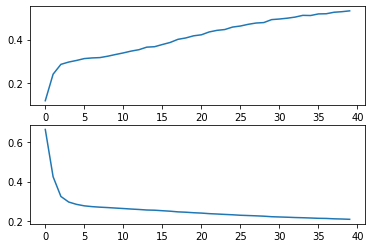

In [ ]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)
plt.show()

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

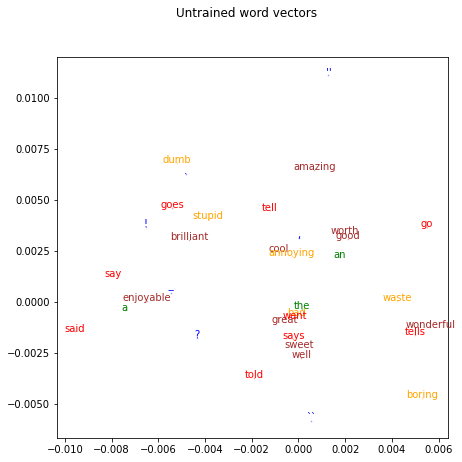

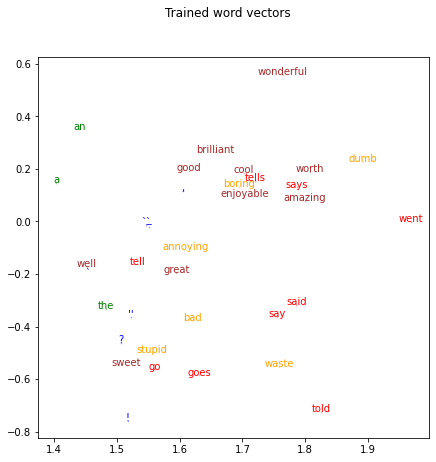

In [ ]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")